# ОИАД. Лабораторная работа №3

## 1. Подготовка данных
1. проверить наличие пропусков и выбросов

2. привести категориальные признаки к числовым

3. вычислить парные корреляции признаков

Пропуски по столбцам:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Доля пропусков по столбцам:
age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64
Выбросов по столбцам:
age         0
bmi         5
charges    19
dtype: int64
Всего строк: 338, строк с хотя бы одним выбросом: 22
Размер после фильтрации: 316


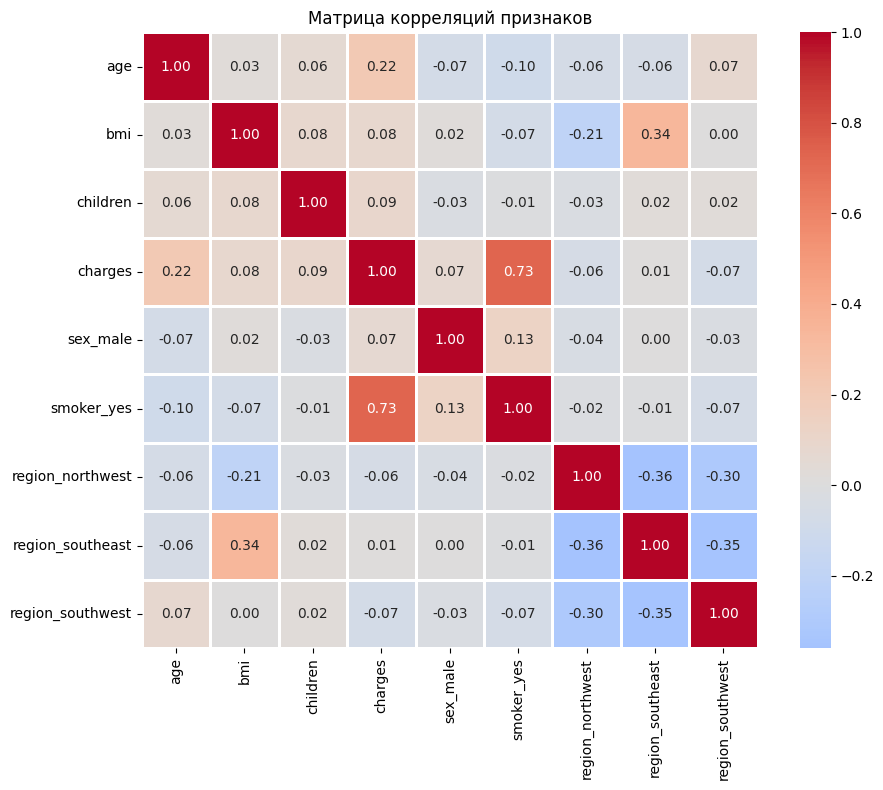


Пары с abs(corr) > 0.9:

Будем удалять признаки:
set()

Форма до удаления: (316, 9)
Форма после удаления: (316, 9)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

num_columns = ["age", "bmi", "children", "charges"]
cat_columns = ["sex", "smoker", "region"]

CORR_THRESHOLD = 0.9

df = pd.read_csv("../datasets/insurance_train.csv")
df_test = pd.read_csv('../datasets/insurance_test.csv')

print("Пропуски по столбцам:")
print(df.isnull().sum())
print("\nДоля пропусков по столбцам:")
print(df.isnull().mean())
  

# --- 1. Обнаружение выбросов
def detect_outliers_iqr_mask(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper)


cols = ['age', 'bmi', 'charges']
outlier_flags = pd.DataFrame({col: detect_outliers_iqr_mask(df[col]) for col in cols})

rows_with_any_outlier = outlier_flags.any(axis=1)

print("Выбросов по столбцам:")
print(outlier_flags.sum())

print(f"Всего строк: {len(df)}, строк с хотя бы одним выбросом: {rows_with_any_outlier.sum()}")

df = df[~rows_with_any_outlier].copy()
print(f"Размер после фильтрации: {len(df)}")

# 2. Кодирование категориальных признаков 

df = pd.get_dummies(df, columns=cat_columns, drop_first=True, dtype=float)
df_test = pd.get_dummies(df_test, columns=cat_columns, drop_first=True, dtype=float)

# 3. Парные корреляции 

corr_matrix = df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Матрица корреляций признаков')
plt.tight_layout()
plt.show()

# Удаление сильно коррелирующих признаков
def find_highly_correlated(corr_matrix, threshold=0.8):
    cols = corr_matrix.columns
    correlated_pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                correlated_pairs.append((cols[i], cols[j], corr_matrix.iloc[i,j]))
    return correlated_pairs

pairs = find_highly_correlated(corr_matrix, CORR_THRESHOLD)
print(f"\nПары с abs(corr) > {CORR_THRESHOLD}:")
for a,b,c in pairs:
    print(f"  {a} <-> {b} : corr = {c:.3f}")

to_drop = set()
for a, b, cval in pairs:
    mean_corr_a = corr_matrix[a].abs().mean()
    mean_corr_b = corr_matrix[b].abs().mean()
    if mean_corr_a > mean_corr_b and a != 'charges':
        to_drop.add(a)
    else:
        to_drop.add(b)

print("\nБудем удалять признаки:")
print(to_drop)

prevsp = df.shape
df = df.drop(columns=list(to_drop))
df_test = df_test.drop(columns=list(to_drop))
print("\nФорма до удаления:", prevsp)
print("Форма после удаления:", df.shape)


## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)

Для линейной регрессии $y = Xw$ минимизируем функцию потерь $Q(w) = ||Xw - y||^2$. Аналитическое решение получается приравниванием градиента к нулю: $w^* = (X^TX)^{-1}X^Ty$

2. численно, с помощью методов градиентного спуска (реализовать самому)

In [ ]:
# Разделение на признаки и целевую переменную
X_train = df.drop('charges', axis=1).values.astype(np.float64)
y_train = df['charges'].values.astype(np.float64)

X_test = df_test.drop('charges', axis=1).values.astype(np.float64)
y_test = df_test['charges'].values.astype(np.float64)

X_train = np.column_stack([np.ones(len(X_train)), X_train])
X_test = np.column_stack([np.ones(len(X_test)), X_test])

feature_names = ['const'] + df.drop('charges', axis=1).columns.tolist()

def linear_regression_analytical(X, y):
    # w = (X^T * X)^(-1) * X^T * y
    XtX = X.T @ X
    Xty = X.T @ y
    
    # обратимость матрицы
    XtX_inv = np.linalg.inv(XtX)
    w = XtX_inv @ Xty
    return w


def gradient_descent(X, y, learning_rate=0.0000001, n_iterations=10000):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    
    w = np.zeros(n_features)
    
    for i in range(n_iterations):
        y_pred = X @ w
        
        error = y_pred - y

        # Градиент: grad = 2/n * X^T * (Xw - y)
        gradient = (2/n_samples) * (X.T @ error)
        
        w = w - learning_rate * gradient        

    return w


w_analytical = linear_regression_analytical(X_train, y_train)

print("Веса модели (аналитическое решение):")
for i, name in enumerate(feature_names):
    print(f"{name:20s}: {w_analytical[i]:10.2f}")
    
    

w_gradient = gradient_descent(X_train, y_train, learning_rate=0.00038, n_iterations=500000)



print("\nВеса модели (градиентный спуск):")
for i, name in enumerate(feature_names):
    print(f"{name:20s}: {w_gradient[i]:10.2f}")


Веса модели (аналитическое решение):
const               :   -6165.36
age                 :     212.55
bmi                 :     232.11
children            :     578.85
sex_male            :    -236.93
smoker_yes          :   19899.32
region_northwest    :    -927.05
region_southeast    :   -1213.50
region_southwest    :   -1809.18

Веса модели (градиентный спуск):
const               :   -6164.32
age                 :     212.54
bmi                 :     232.09
children            :     578.85
sex_male            :    -236.99
smoker_yes          :   19899.23
region_northwest    :    -927.24
region_southeast    :   -1213.56
region_southwest    :   -1809.31


## 3. Добавление регуляризации


### 3.1 Гребневая регрессия (L2-регуляризация) - аналитическое решение

Добавляем штраф за большие веса: $Q(w) = ||Xw - y||^2 + \alpha||w||^2$. Это помогает избежать переобучения и делает модель более устойчивой. Аналитическое решение: $w^* = (X^TX + \alpha I)^{-1}X^Ty$

### 3.2 Гребневая регрессия - численное решение

Градиент для регуляризованной функции потерь: $\nabla Q = 2X^T(Xw - y) + 2\alpha w$

In [ ]:
def ridge_regression_analytical(X, y, alpha=1.0):
    n_features = X.shape[1]
    
    # w = (X^T*X + alpha*I)^(-1) * X^T*y
    XtX = X.T @ X
    I = np.eye(n_features)
    # Не регуляризируем свободный член
    I[0, 0] = 0
    
    XtX_reg = XtX + alpha * I
    Xty = X.T @ y
    
    w = np.linalg.inv(XtX_reg) @ Xty
    return w


alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ridge_results = []


for alpha in alphas:
    w_ridge = ridge_regression_analytical(X_train, y_train, alpha=alpha)
    
    y_pred_test = X_test @ w_ridge
    mse_test = np.mean((y_pred_test - y_test)**2)
    
    ridge_results.append({
        'alpha': alpha,
        'mse_test': mse_test,
        'weights': w_ridge
    })
    
    print(f"Alpha = {alpha:8.3f}, MSE = {mse_test:12.2f}")

best_result = min(ridge_results, key=lambda x: x['mse_test'])
best_alpha = best_result['alpha']
w_ridge_best = best_result['weights']

print(f"\nЛучший alpha = {best_alpha}")
print(f"MSE с лучшим alpha: {best_result['mse_test']:.2f}")


def ridge_gradient_descent(X, y, alpha=1.0, learning_rate=0.0000001, n_iterations=10000):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    
    w = np.zeros(n_features)
    
    for i in range(n_iterations):
        y_pred = X @ w
        error = y_pred - y
    
        # Градиент с регуляризацией
        gradient = (2/n_samples) * (X.T @ error)
        # Добавляем регуляризационный член (кроме свободного члена)
        gradient[1:] += (2*alpha/n_samples) * w[1:]
        
        w = w - learning_rate * gradient
    
    return w

print("\nПодбор оптимального alpha:")

alphas_grad = [0.1, 1, 10, 100, 1000]
ridge_grad_results = []

for alpha in alphas_grad:
    w_ridge_grad = ridge_gradient_descent(
        X_train, y_train, 
        alpha=alpha, 
        learning_rate=0.00038,
        n_iterations=500000
    )
    
    y_pred_test = X_test @ w_ridge_grad
    mse_test = np.mean((y_pred_test - y_test)**2)
    
    ridge_grad_results.append({
        'alpha': alpha,
        'mse_test': mse_test,
        'weights': w_ridge_grad
    })
    
    print(f"Alpha = {alpha:8.1f}, MSE (test) = {mse_test:12.2f}")

best_grad_result = min(ridge_grad_results, key=lambda x: x['mse_test'])
best_alpha_grad = best_grad_result['alpha']
w_ridge_gradient = best_grad_result['weights']

print(f"\nЛучший alpha = {best_alpha_grad} (минимальная MSE на тестовой выборке)")
print(f"MSE с лучшим alpha: {best_grad_result['mse_test']:.2f}")

Alpha =    0.001, MSE =  37409447.44
Alpha =    0.010, MSE =  37414426.46
Alpha =    0.100, MSE =  37464367.78
Alpha =    1.000, MSE =  37978038.81
Alpha =   10.000, MSE =  43917017.83
Alpha =  100.000, MSE =  84178247.49
Alpha = 1000.000, MSE = 120359770.36
Alpha = 10000.000, MSE = 128439923.48

Лучший alpha = 0.001
MSE с лучшим alpha: 37409447.44

Подбор оптимального alpha:
Alpha =      0.1, MSE (test) =  37464794.18
Alpha =      1.0, MSE (test) =  37978441.12
Alpha =     10.0, MSE (test) =  43917271.64
Alpha =    100.0, MSE (test) =  84178268.74
Alpha =   1000.0, MSE (test) = 120359761.58

Лучший alpha = 0.1 (минимальная MSE на тестовой выборке)
MSE с лучшим alpha: 37464794.18


## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [17]:
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(calculate_mse(y_true, y_pred))

# 1. Константная модель
y_mean = y_train.mean()
y_pred_const = np.full(len(y_test), y_mean)
mse_const = calculate_mse(y_test, y_pred_const)
rmse_const = calculate_rmse(y_test, y_pred_const)

# 2. Линейная регрессия (аналитическое решение)
y_pred_linear = X_test @ w_analytical
mse_linear = calculate_mse(y_test, y_pred_linear)
rmse_linear = calculate_rmse(y_test, y_pred_linear)

# 3. Линейная регрессия (градиентный спуск)
y_pred_gradient = X_test @ w_gradient
mse_gradient = calculate_mse(y_test, y_pred_gradient)
rmse_gradient = calculate_rmse(y_test, y_pred_gradient)

# 4. Гребневая регрессия (аналитическое решение)
y_pred_ridge = X_test @ w_ridge_best
mse_ridge = calculate_mse(y_test, y_pred_ridge)
rmse_ridge = calculate_rmse(y_test, y_pred_ridge)

# 5. Гребневая регрессия (градиентный спуск)
y_pred_ridge_grad = X_test @ w_ridge_gradient
mse_ridge_grad = calculate_mse(y_test, y_pred_ridge_grad)
rmse_ridge_grad = calculate_rmse(y_test, y_pred_ridge_grad)

results = pd.DataFrame({
    'Модель': [
        'Константная (baseline)',
        'Линейная регрессия (аналитич.)',
        'Линейная регрессия (град. спуск)',
        'Ridge регрессия (аналитич.)',
        'Ridge регрессия (град. спуск)'
    ],
    'MSE': [mse_const, mse_linear, mse_gradient, mse_ridge, mse_ridge_grad],
    'RMSE': [rmse_const, rmse_linear, rmse_gradient, rmse_ridge, rmse_ridge_grad]
})

results = results.sort_values('MSE')
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print("="*60)
print(results.to_string(index=False))
print("="*60)


РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:
                          Модель          MSE         RMSE
  Линейная регрессия (аналитич.) 3.740889e+07  6116.281091
Линейная регрессия (град. спуск) 3.740932e+07  6116.316184
     Ridge регрессия (аналитич.) 3.740945e+07  6116.326303
   Ridge регрессия (град. спуск) 3.746479e+07  6120.849139
          Константная (baseline) 1.412740e+08 11885.873776


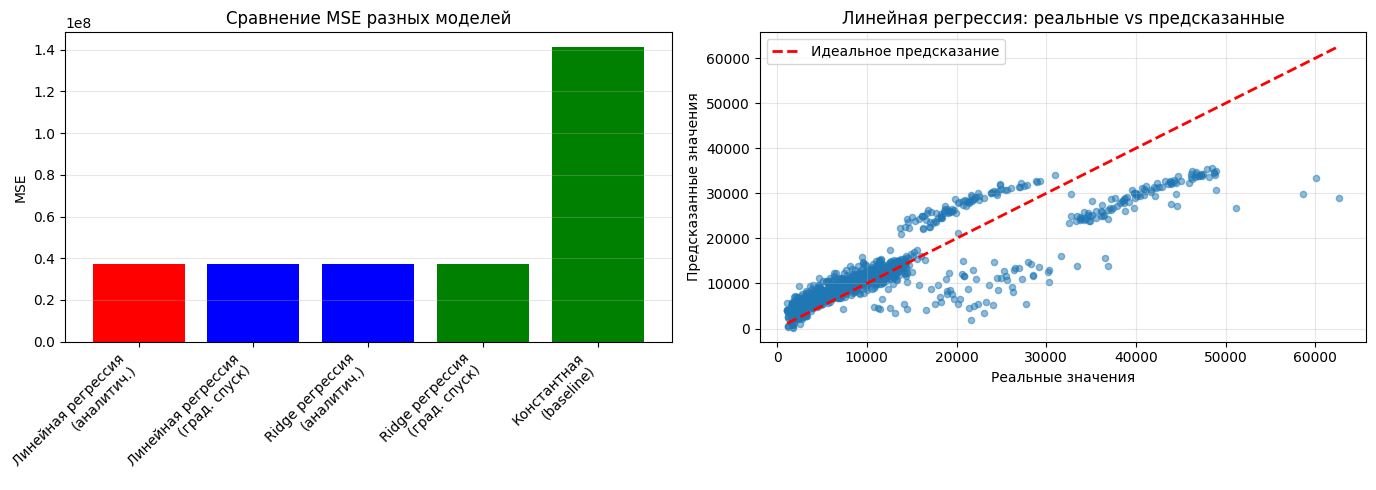

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Сравнение MSE
models = results['Модель'].str.replace(' (', '\n(', regex=False)
axes[0].bar(range(len(results)), results['MSE'], color=['red', 'blue', 'blue', 'green', 'green'])
axes[0].set_xticks(range(len(results)))
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].set_ylabel('MSE')
axes[0].set_title('Сравнение MSE разных моделей')
axes[0].grid(axis='y', alpha=0.3)

# График 2: Реальные vs предсказанные значения
axes[1].scatter(y_test, y_pred_linear, alpha=0.5, s=20)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Идеальное предсказание')
axes[1].set_xlabel('Реальные значения')
axes[1].set_ylabel('Предсказанные значения')
axes[1].set_title('Линейная регрессия: реальные vs предсказанные')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()